In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


device(type='cpu')

In [178]:
batch_size = 1

In [179]:
dataset = datasets.ImageFolder(root='./data-nodules2d',transform = transforms.Compose([
    transforms.ToTensor()]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset.imgs), len(dataloader)

(39274, 39274)

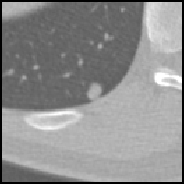

In [182]:
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [184]:
fixed_x.shape

torch.Size([1, 3, 180, 180])

In [190]:
x = fixed_x[0][0]
x.shape

torch.Size([180, 180])

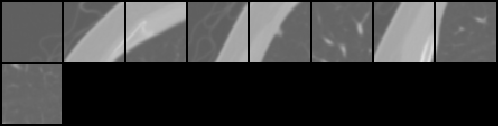

In [89]:
save_image(tiled, 'tiled.png')
Image('tiled.png')

In [209]:
loss = nn.MSELoss()

In [276]:
x = torch.randn(180, 180)
x.shape

x.unfold(0,60,60).

torch.Size([3, 180, 60])

In [334]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 56 * 56, 64)
        self.regression = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64*56*56)
        self.convTrans1 = nn.ConvTranspose2d(64,32,3,1)
        self.convTrans2 = nn.ConvTranspose2d(32,1,3,1)
    
    def tiling(self, x):
        x = x[0, 0]
        tiled = x.unfold(0,60,60).unfold(1,60,60)
        tiled = tiled.reshape(9, 1, 60, 60)
        return tiled
    
    def untiling(self,x):
        a = torch.cat([x[0],x[1],x[2]],dim = 1)
        b = torch.cat([x[3],x[4],x[5]],dim = 1)
        c = torch.cat([x[6],x[7],x[8]],dim = 1)
        x = torch.cat([a,b,c],dim = 2)
        return x
    
    def upsample(self, x):
        x = self.fc2(x)
        x = x.reshape(9,-1,56,56)
        x = self.convTrans1(x)
        x = F.relu(x)
        x = self.convTrans2(x)
        return x

    def downsample(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.reshape(9,-1)
        x = self.fc1(x)
        return x
    
    def forward(self, x):
        x = self.tiling(x)
        x = self.downsample(x)
        I_dprime = self.untiling(self.upsample(x))
        
        Vprime = []
        for i in range(len(x)):
            Vnot_i = self.pool(x, i)
            vprime_i = self.regression(Vnot_i)
            Vprime.append(vprime_i)
        Vprime = torch.cat(Vprime, dim = 0)
        I_prime = self.untiling(self.upsample(Vprime))

        return I_prime,I_dprime
    
    def pool(self, x, i):
        x = torch.cat((x[0:i], x[i+1:]))
        x = x.mean(0)
        x = x.reshape(1,-1)
        return x

In [335]:
model = Net()
optimizer = optim.Adam(model.parameters())

In [348]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200704, out_features=64, bias=True)
  (regression): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=200704, bias=True)
  (convTrans1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (convTrans2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [338]:
def train(train_loader):
    epoch = 1
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        Iprime,Idprime = model(data)
        data = data[:, 0]
#         print(data.shape, Iprime.shape)
        l1 = loss(data, Iprime)
        l2 = loss(data, Idprime)
        (l1+l2).backward()
        optimizer.step()
        
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), l1.item(),l2.item()))

In [339]:
train(dataloader)

Train Epoch: 1 [0/39274 (0%)]	Loss: 256.739349 589.783508
Train Epoch: 1 [2/39274 (0%)]	Loss: 5.189409 14.116772
Train Epoch: 1 [4/39274 (0%)]	Loss: 19.684443 40.659962
Train Epoch: 1 [6/39274 (0%)]	Loss: 8.058577 6.771278
Train Epoch: 1 [8/39274 (0%)]	Loss: 2.182223 4.509753
Train Epoch: 1 [10/39274 (0%)]	Loss: 0.733780 7.107648
Train Epoch: 1 [12/39274 (0%)]	Loss: 0.351146 5.192680
Train Epoch: 1 [14/39274 (0%)]	Loss: 0.373413 3.394212
Train Epoch: 1 [16/39274 (0%)]	Loss: 0.425475 1.926204
Train Epoch: 1 [18/39274 (0%)]	Loss: 0.299515 1.048119
Train Epoch: 1 [20/39274 (0%)]	Loss: 0.403030 0.845243
Train Epoch: 1 [22/39274 (0%)]	Loss: 0.271521 0.462903
Train Epoch: 1 [24/39274 (0%)]	Loss: 0.321210 0.357226
Train Epoch: 1 [26/39274 (0%)]	Loss: 0.355877 0.334394
Train Epoch: 1 [28/39274 (0%)]	Loss: 0.319264 0.318412
Train Epoch: 1 [30/39274 (0%)]	Loss: 0.220515 0.243877
Train Epoch: 1 [32/39274 (0%)]	Loss: 0.265746 0.269153
Train Epoch: 1 [34/39274 (0%)]	Loss: 0.243935 0.256833
Train Ep

KeyboardInterrupt: 

In [340]:
fixed_x.shape

torch.Size([1, 3, 180, 180])

In [343]:
Iprime, Idprime = model(fixed_x)
Iprime.shape

torch.Size([1, 180, 180])

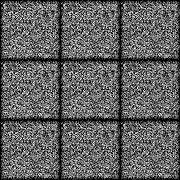

In [344]:
save_image(Iprime, 'real_image.png')
Image('real_image.png')

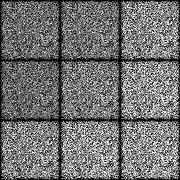

In [347]:
save_image(Idprime, 'real_image.png')
Image('real_image.png')